# Team Assignment - the descriptive Task

#### First Step: Importing

In [31]:
# Install following modules in order to use this notebook:
# conda install -c conda-forge geopandas geopy swifter

# ----------- GPU acceleration - use pandas if you don't got a nvidia gpu -----------
import pandas as pd
#import cudf as pd

# install packages with "conda install -c nvidia -c rapidsai -c numba -c conda-forge -c defaults cudf" 
# only on Linux available
# ----------- GPU acceleration - end -----------
import swifter
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")

import folium
from folium import plugins
from folium.plugins import HeatMap
from geopandas.tools import geocode

from datetime import datetime, timedelta

In [12]:
chg17 = pd.read_csv("chicago_2017.csv")

#### Second Step: Validate and review the Data

In [13]:
chg17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3829014 entries, 0 to 3829013
Data columns (total 8 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   start_time          object
 1   end_time            object
 2   start_station_id    int64 
 3   end_station_id      int64 
 4   start_station_name  object
 5   end_station_name    object
 6   bike_id             int64 
 7   user_type           object
dtypes: int64(3), object(5)
memory usage: 233.7+ MB


In [4]:
# chg17.describe()

In [5]:
chg17.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,3/31/2017 23:59:07,4/1/2017 00:13:24,66,171,Clinton St & Lake St,May St & Cullerton St,5292,Subscriber
1,3/31/2017 23:56:25,4/1/2017 00:00:21,199,26,Wabash Ave & Grand Ave,McClurg Ct & Illinois St,4408,Subscriber
2,3/31/2017 23:55:33,4/1/2017 00:01:21,520,432,Greenview Ave & Jarvis Ave,Clark St & Lunt Ave,696,Subscriber
3,3/31/2017 23:54:46,3/31/2017 23:59:34,110,142,Dearborn St & Erie St,McClurg Ct & Erie St,4915,Subscriber
4,3/31/2017 23:53:33,4/1/2017 00:00:28,327,331,Sheffield Ave & Webster Ave,Halsted St & Blackhawk St (*),4247,Subscriber


Let's have a look at empty values

In [6]:
emptyRows = chg17[chg17.isna().any(axis=1)]
emptyRows

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type


In [7]:
countEmptyRows = len(chg17[chg17.isna().any(axis=1)])
print("There are {} empty rows".format(countEmptyRows))

There are 0 empty rows


As you can see, there are none empty Values

## Usage Visualization:

First we aggregate our data and do some calculation before

In [19]:
# Careful, this step takes some minutes
chg17_timeStamps = chg17.copy()
chg17_timeStamps['start_time'] = pd.to_datetime(chg17_timeStamps['start_time'])
chg17_timeStamps['end_time'] = pd.to_datetime(chg17_timeStamps['end_time'])

In [20]:
chg17_timeStamps.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2017-03-31 23:59:07,2017-04-01 00:13:24,66,171,Clinton St & Lake St,May St & Cullerton St,5292,Subscriber
1,2017-03-31 23:56:25,2017-04-01 00:00:21,199,26,Wabash Ave & Grand Ave,McClurg Ct & Illinois St,4408,Subscriber
2,2017-03-31 23:55:33,2017-04-01 00:01:21,520,432,Greenview Ave & Jarvis Ave,Clark St & Lunt Ave,696,Subscriber
3,2017-03-31 23:54:46,2017-03-31 23:59:34,110,142,Dearborn St & Erie St,McClurg Ct & Erie St,4915,Subscriber
4,2017-03-31 23:53:33,2017-04-01 00:00:28,327,331,Sheffield Ave & Webster Ave,Halsted St & Blackhawk St (*),4247,Subscriber


In [21]:
chg17_timeStamps["date"] = chg17_timeStamps["start_time"].swifter.progress_bar(False).apply(lambda x: x.date()) 
chg17_timeStamps["travel_time"] = chg17_timeStamps["end_time"] - chg17_timeStamps["start_time"]
chg17_timeStamps["hour"] = chg17_timeStamps["start_time"].swifter.progress_bar(False).apply(lambda x: x.hour) 
chg17_timeStamps["weekday"] = chg17_timeStamps["start_time"].swifter.progress_bar(False).apply(lambda x: x.weekday()) 
chg17_timeStamps["week"] = chg17_timeStamps["start_time"].swifter.progress_bar(False).apply(lambda x: x.isocalendar()[1]) 
chg17_timeStamps["month"] = chg17_timeStamps["start_time"].swifter.progress_bar(False).apply(lambda x: x.month) 
chg17_timeStamps.sort_values(["date","bike_id"], inplace = True)

In [22]:
chg17_timeStamps.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,date,travel_time,hour,weekday,week,month
430052,2017-01-01 20:54:49,2017-01-01 21:04:30,27,302,Larrabee St & North Ave,Sheffield Ave & Wrightwood Ave,8,Subscriber,2017-01-01,0 days 00:09:41,20,6,52,1
431086,2017-01-01 12:38:02,2017-01-01 12:41:07,138,27,Clybourn Ave & Division St,Larrabee St & North Ave,8,Subscriber,2017-01-01,0 days 00:03:05,12,6,52,1
431351,2017-01-01 10:33:57,2017-01-01 10:37:29,27,138,Larrabee St & North Ave,Clybourn Ave & Division St,8,Subscriber,2017-01-01,0 days 00:03:32,10,6,52,1
431246,2017-01-01 11:35:55,2017-01-01 11:57:05,116,88,Western Ave & Winnebago Ave,Racine Ave & Randolph St,27,Customer,2017-01-01,0 days 00:21:10,11,6,52,1
430271,2017-01-01 17:45:56,2017-01-01 18:01:38,231,231,Sheridan Rd & Montrose Ave,Sheridan Rd & Montrose Ave,31,Subscriber,2017-01-01,0 days 00:15:42,17,6,52,1


### Let's take a look at different usages
At first some usage data over the year

In [27]:
chg17_usage = chg17_timeStamps.groupby(["date"])["bike_id"].count()
chg17_usage = pd.DataFrame(chg17_usage)

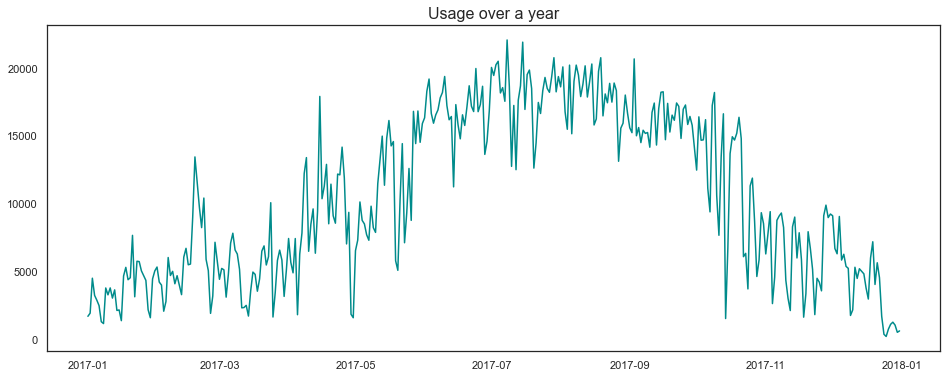

In [9]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(chg17_usage, color='darkcyan')

ax.set_title("Usage over a year", fontsize=16)
plt.show()

Breaking this into our to costumer types: costumer, subscriber.

For simplicity reasons we are grouping by week now

In [10]:
data_range = pd.date_range('2017-01-01', '2017-12-31')

In [11]:
chg17_usage = chg17_timeStamps.groupby(["week"])["bike_id"].count()
chg17_usage = pd.DataFrame(chg17_usage)

In [12]:
chg17_usage_subs = chg17_timeStamps[chg17_timeStamps["user_type"]=="Subscriber"].groupby(["week"])["bike_id"].count()
chg17_usage_subs = pd.DataFrame(chg17_usage_subs)

In [13]:
chg17_usage_costu = chg17_timeStamps[chg17_timeStamps["user_type"]=="Customer"].groupby(["week"])["bike_id"].count()
chg17_usage_costu = pd.DataFrame(chg17_usage_costu)

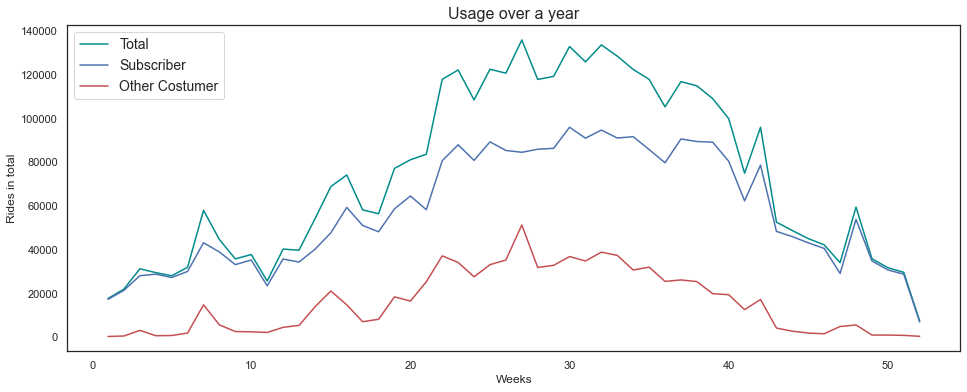

In [14]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(chg17_usage, label="Total", color='darkcyan')
ax.plot(chg17_usage_subs, label="Subscriber", color='b')
ax.plot(chg17_usage_costu, label="Other Costumer", color='r')

ax.set_title("Usage over a year", fontsize=16)
ax.set_ylabel("Rides in total")
ax.set_xlabel("Weeks")
ax.legend(fontsize=14, loc="upper left")
plt.show()

In [15]:
chg17_usage = chg17_timeStamps.groupby(["date","month"])["bike_id"].count()
chg17_usage = pd.DataFrame(chg17_usage)

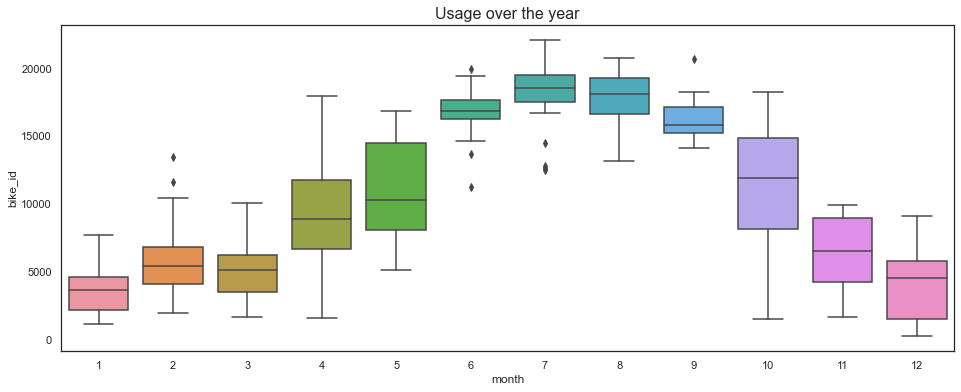

In [16]:
fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(x = chg17_usage.index.get_level_values(1),
            y = chg17_usage["bike_id"],
            ax=ax)
ax.set_title("Usage over the year", fontsize=16)
plt.show()

Then we take a look at some usage data per individual day. We compare each week day to each other

In [17]:
chg17_usage = chg17_timeStamps.groupby(["date","weekday"])["bike_id"].count()
chg17_usage = pd.DataFrame(chg17_usage)

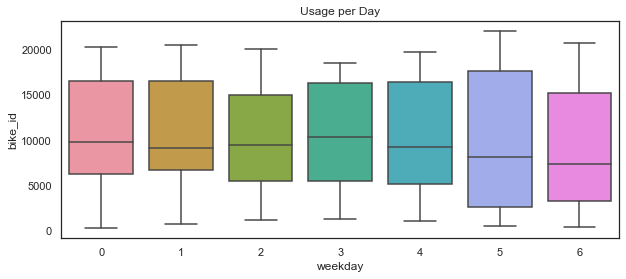

In [18]:
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(x = chg17_usage.index.get_level_values(1),
            y = chg17_usage["bike_id"],
            ax=ax)
ax.set_title("Usage per Day")
plt.show()

We continue with some analyses of the usage over the day

In [19]:
chg17_usage = chg17_timeStamps.groupby(["date","hour"])["bike_id"].count()
chg17_usage = pd.DataFrame(chg17_usage)

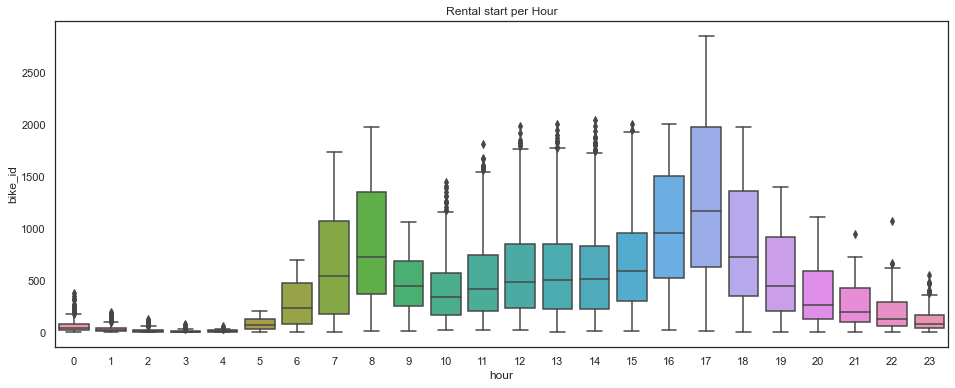

In [20]:
fig, ax = plt.subplots(figsize=(16,6))

sns.boxplot(x = chg17_usage.index.get_level_values(1),
            y = chg17_usage["bike_id"],
            ax=ax)
ax.set_title("Rental start per Hour")
plt.show()

### We now take a look at availability time
#### Time where the product is not in use is often very important

At first we need to extract the coordinates from our station names

In [137]:
chg17_stations = chg17.copy()

In [26]:
def getLocation(x):
    try:
        location = geocode(x, provider="nominatim", user_agent='my_request')
        point = location.geometry.iloc[0]
        return list(zip(round(point.y, 5), round(point.x, 5)))
    except:
        return 'NaN'

Example of geocode:

In [25]:
geocode("Hatzfeldstraße 3", provider="nominatim", user_agent='my_request')["geometry"]

0    POINT (7.06991 50.97302)
Name: geometry, dtype: geometry

#### Create dictionarys of the unique adresses
We safe them in a file to permanently have access

In [27]:
UniqueAdresses = chg17['start_station_name'].unique()
locDict = dict(zip(UniqueAdresses, pd.Series(UniqueAdresses).apply(lambda x: getLocation(x))))

In [24]:
UniqueAdresses2 = chg17['end_station_name'].unique()
locDict2 = dict(zip(UniqueAdresses2, pd.Series(UniqueAdresses2).apply(lambda x: getLocation(x))))

check if the list of stations are identical

In [26]:
set(locDict.keys()) == set(locDict2.keys())

True

In [12]:
# storing the location dictionary into a json file 
with open('locDict.json', 'w') as file:
     file.write(json.dumps(locDict))

In [138]:
# retrieve the location dictionary from the json file
with open('locDict.json', 'r') as file:
     newLocDict = json.loads(file.read())

Now we can map the location coordinates to our pandas dataframe

In [139]:
def convertToTuple(x):
    if not x == "NaN":
        return tuple(map(float, x[1:-1].split(",")))
    else:
        return float('NaN')

In [140]:
chg17_stations['start_station_coordinates'] = chg17_stations['start_station_name'].map(newLocDict)
chg17_stations['start_station_coordinates'] = chg17_stations['start_station_coordinates'].swifter.apply(lambda x: convertToTuple(x))

Pandas Apply:   0%|          | 0/3829014 [00:00<?, ?it/s]

In [141]:
chg17_stations.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_station_coordinates
0,3/31/2017 23:59:07,4/1/2017 00:13:24,66,171,Clinton St & Lake St,May St & Cullerton St,5292,Subscriber,"(41.8856, -87.6415)"
1,3/31/2017 23:56:25,4/1/2017 00:00:21,199,26,Wabash Ave & Grand Ave,McClurg Ct & Illinois St,4408,Subscriber,"(41.8917, -87.6269)"
2,3/31/2017 23:55:33,4/1/2017 00:01:21,520,432,Greenview Ave & Jarvis Ave,Clark St & Lunt Ave,696,Subscriber,"(42.016, -87.6684)"
3,3/31/2017 23:54:46,3/31/2017 23:59:34,110,142,Dearborn St & Erie St,McClurg Ct & Erie St,4915,Subscriber,"(41.894, -87.6294)"
4,3/31/2017 23:53:33,4/1/2017 00:00:28,327,331,Sheffield Ave & Webster Ave,Halsted St & Blackhawk St (*),4247,Subscriber,"(41.9217, -87.6537)"


There are still some 'NaN' values in our coordinates where geocode didn't find a location according to the address

In [120]:
chg17_stations[chg17_stations["start_station_coordinates"].isnull()==True]["start_station_name"].count()

29474

In [144]:
chg17_stations = chg17_stations[chg17_stations["start_station_coordinates"].isnull()==False]

#### Finally we can start using our coordinates to map out some features
At first we map out the station locations:

In [183]:
positions = list(chg17_stations["start_station_coordinates"].unique())

chg17_stations_map = folium.Map(location=(41.8856, -87.6415),  
                                tiles='Stamen Toner',
                                zoom_start=12, control_scale=True, 
                                max_zoom=20)

for position in positions:
    folium.CircleMarker(radius=10, location=position, popup='The Waterfront', 
                                 color='crimson', fill_color='crimson').add_to(chg17_stations_map)
    
chg17_stations_map

Now let's take a look at 

In [182]:
chg17_usage = chg17_timeStamps.groupby(["start_station_name"])["bike_id"].count()
chg17_usage = pd.DataFrame({'start_station_name':chg17_usage.index, 'bike_id_count':chg17_usage.values})
chg17_usage["start_station_coordinates"] = chg17_usage["start_station_name"].map(newLocDict)
chg17_usage

,start_station_name,bike_id_count,start_station_coordinates
0,2112 W Peterson Ave,562,"(41.991, -87.6828)"
1,63rd St Beach,1045,"(41.7828, -87.5746)"
2,900 W Harrison St,6230,"(42.0143, -94.3863)"
3,Aberdeen St & Jackson Blvd,9835,"(41.8777, -87.6548)"
4,Aberdeen St & Monroe St,10540,"(41.8804, -87.6552)"
...,...,...,...
588,Wood St & Taylor St,6716,"(41.8692, -87.671)"
589,Woodlawn Ave & 55th St,3113,"(41.7953, -87.5965)"
590,Woodlawn Ave & 75th St,19,"(41.7591, -87.5958)"
591,Woodlawn Ave & Lake Park Ave,1023,"(41.8141, -87.597)"


In [147]:
chg17_heat_map = folium.Map(location=(41.8856, -87.6415),
                            tiles='OpenStreetMap',
                            zoom_start=12,
                            control_scale=True,
                            max_zoom=20)



In [ ]:
chg17_heat_map.add_child(plugins.HeatMap(chg17_stations["start_station_coordinates"]))